In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
from scipy import stats
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload
from scipy import interpolate
import copy
from sklearn.metrics import confusion_matrix

# Splines
from scipy.interpolate import interp1d

# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

# Problem 5

## Data

In [2]:
data = np.array([[ 203.41 , -89.37 ],
                 [ 203.435, -94.88 ],
                 [ 203.46 , -101.25 ],
                 [ 203.484, -106.52 ],
                 [ 203.509, -108.66 ],
                 [ 203.534, -114.25 ],
                 [ 203.558, -114.30 ],
                 [ 203.583, -117.66 ],
                 [ 203.608, -122.45 ]])

sol = data[:,0]
temp = data[:,1]

## Vizualize data

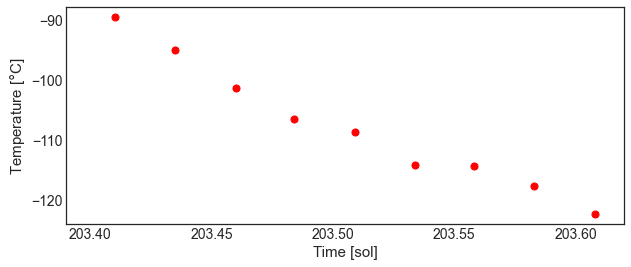

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

ax.scatter(sol, temp, s=50, color='r', label='Viking 1 Data', zorder=3)
ax.set_xlabel('Time [sol]', fontsize=15)
ax.set_ylabel(r'Temperature [$\degree$C]', fontsize=15)
plt.xlim(203.39,203.62)
ax.set_xticks(np.arange(203.40, 203.61, 0.05))
ax.set_yticks(np.arange(-120,-89,10));

## Define splines

In [10]:
# Define linear spline
linear_spline = interp1d(sol, temp, kind='linear')

# Define cubic spline
cubic_spline = interp1d(sol, temp, kind='cubic')

# 5A

**What are the estimates of the temperature on sol 203.570
from the created linear-spline, as well as the created cubic/
PCHIP-spline?**

In [11]:
# Define sol's to estimate temperature at
sol_est = 203.570
print(f'The LINEAR spline estimates the temperatur at {sol_est} sol to be {linear_spline(sol_est):.4f} degrees')
print(f'The CUBIC spline estimates the temperatur at {sol_est} sol to be {cubic_spline(sol_est):.4f} degrees')

The LINEAR spline estimates the temperatur at 203.57 sol to be -115.9128 degrees
The CUBIC spline estimates the temperatur at 203.57 sol to be -115.3253 degrees


# 5B

**Make a scatter plot of temperature versus time of the
interpolated temperatures from the linear-spline as well as
the cubic/PCHIP-spline covering the time range from
203.410 sol to 203.608 sol. To ensure we can see any interesting features of the linear and cubic/
PCHIP splines, make sure there are at least 200 points for each
interpolation. During sol 203.410 to 203.608, if we know that the
temperature should be continuously dropping, are there
any regions of time that we should look at more closely for
the cubic/PCHIP spline to make sure that the interpolated
temperature is monotonically decreasing?**

In [13]:
# Define array to evaluate spline in
xlim = (203.410, 203.608)
N_points = 250
x_arr = np.linspace(*xlim, N_points)
resolution = x_arr[1] - x_arr[0]

# Use splines
y_linear = linear_spline(x_arr)
y_cubic = cubic_spline(x_arr)

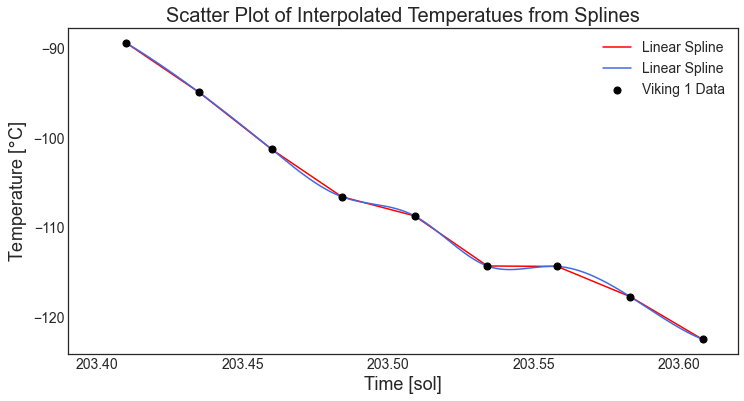

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(sol, temp, s=50, color='k', label='Viking 1 Data', zorder=3)
ax.plot(x_arr, y_linear, color='r', label='Linear Spline', zorder=2)
ax.plot(x_arr, y_cubic, color='royalblue', label='Linear Spline', zorder=2)
ax.set_title('Scatter Plot of Interpolated Temperatues from Splines', fontsize=20)
ax.set_xlabel('Time [sol]', fontsize=18)
ax.set_ylabel(r'Temperature [$\degree$C]', fontsize=18)
ax.legend()

plt.xlim(203.39,203.62)
ax.set_xticks(np.arange(203.40, 203.61, 0.05))
ax.set_yticks(np.arange(-120,-89,10));

We check whether the temperature is continously dropping, by taking the difference between points: temp[i] - temp[i-1]. If this value is ever positive, the first value (i-1) is largest, and the temperature has not dropped.

In [19]:
# Compute differences
linear_diff = np.diff(y_linear)
cubic_diff = np.diff(y_cubic)

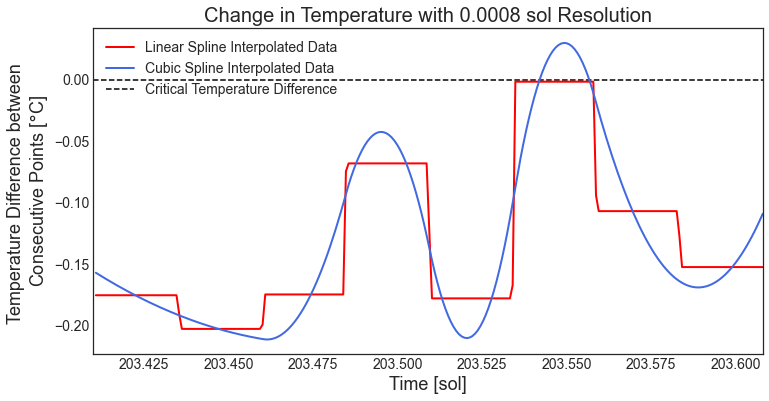

In [27]:
# Plot results
fig, ax = plt.subplots(figsize=(12,6))

# Plot differences
x_diff = xlim[0] + np.cumsum( np.diff(x_arr) )
ax.plot(x_diff, linear_diff, color='r', linewidth=2,  label='Linear Spline Interpolated Data')
ax.plot(x_diff, cubic_diff, color='royalblue', linewidth=2, label='Cubic Spline Interpolated Data')

# Mark the cross to positive vals
ax.hlines(0, *xlim, color='k', linestyle='dashed', label='Critical Temperature Difference')


ax.legend()
ax.set_title(f'Change in Temperature with {resolution:.4f} sol Resolution', fontsize=20)
ax.set_xlabel('Time [sol]', fontsize=18)
ax.set_ylabel(f'Temperature Difference between \nConsecutive Points'+ f' [$\degree$C]', fontsize=18)
plt.xlim(*xlim);

In [28]:
# Time interval to be careful of with the cubic spline
cubic_mask = np.where(cubic_diff >= 0)
cubic_danger_interval = x_diff[cubic_mask]
print(f'The cubic spline violates the condition in the time interval {cubic_danger_interval[0]:.4f} sol to'
      + f' {cubic_danger_interval[-1]:.4f} sol')

# Check linear for good measure
linear_mask = np.where(linear_diff >= 0)
linear_danger_interval = x_diff[linear_mask]
linear_danger_interval

The cubic spline violates the condition in the time interval 203.5428 sol to 203.5563 sol


array([], dtype=float64)

# 5C

**Imagine that proposed electronics components for a Mars
rover, or other Mars planetary-surface exploration vehicle,
are unable to sustain temperature changes of more than
0.09 C within 0.0004 sol. Would new electronics be needed with more robustness to
temperature fluctuations according to your interpolation(s)
to the Viking 1 data?**

To solve this we need to evaluate the splines at points that are seperated by 0.0004 sol and repeat the procedure from 5B

In [29]:
# To solve this we need to evaluate the splines at points that are seperated by 0.0004 sol 
# and repeat the procedure from 5B
sol_resolution = 0.0004

# Define array to evaluate spline in
x_arr = np.arange(np.min(sol)+1e-3, np.max(sol), sol_resolution)

# Use splines
y_linear = linear_spline(x_arr)
y_cubic = cubic_spline(x_arr)

# Compute differences
linear_diff = np.diff(y_linear)
cubic_diff = np.diff(y_cubic)

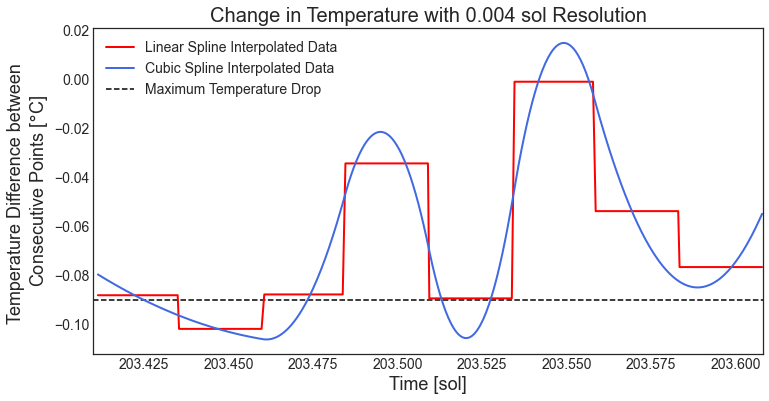

In [30]:
# Plot results
fig, ax = plt.subplots(figsize=(12,6))

# Plot differences
x_diff = np.min(sol)+1e-3 + np.cumsum( np.diff(x_arr) )
ax.plot(x_diff, linear_diff, color='r', linewidth=2,  label='Linear Spline Interpolated Data')
ax.plot(x_diff, cubic_diff, color='royalblue', linewidth=2, label='Cubic Spline Interpolated Data')

# Mark the cross to positive vals
ax.hlines(-0.09, *xlim, color='k', linestyle='dashed', label='Maximum Temperature Drop')

# Pretty
ax.legend()
ax.set_title('Change in Temperature with 0.004 sol Resolution', fontsize=20)
ax.set_xlabel('Time [sol]', fontsize=18)
ax.set_ylabel(f'Temperature Difference between \nConsecutive Points'+ f' [$\degree$C]', fontsize=18)
plt.xlim(*xlim);

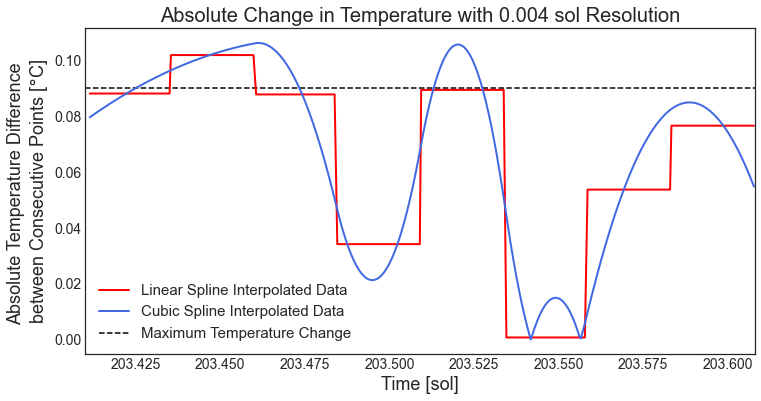

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot differences
x_diff = np.min(sol)+1e-3 + np.cumsum( np.diff(x_arr) )
ax.plot(x_diff, np.abs(linear_diff), color='r', linewidth=2,  label='Linear Spline Interpolated Data')
ax.plot(x_diff, np.abs(cubic_diff), color='royalblue', linewidth=2, label='Cubic Spline Interpolated Data')

# Mark the cross to positive vals
ax.hlines(0.09, *xlim, color='k', linestyle='dashed', label='Maximum Temperature Change')

# Pretty
ax.legend(prop={'size':15})
ax.set_title('Absolute Change in Temperature with 0.004 sol Resolution', fontsize=20)
ax.set_xlabel('Time [sol]', fontsize=18)
ax.set_ylabel(f'Absolute Temperature Difference \nbetween Consecutive Points'+ f' [$\degree$C]', fontsize=18)
plt.xlim(*xlim);